In [1]:
!pip install pandas
import numpy as np
import pandas as pd
import t2_utils as t2
import time 
from ast import literal_eval
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\richa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# change the file path here
file_path_base = r"G:\Other computers\Mein Computer\JKU\1.Semester-WS2023\MultimediaSearchAndRetrieval\\"
file_path_info = file_path_base + "id_information_mmsr.tsv" 
file_path_word2vec = file_path_base + "id_lyrics_word2vec_mmsr.tsv"
file_path_tfidf = file_path_base + "id_lyrics_tf-idf_mmsr.tsv"
file_path_bert = file_path_base + "id_lyrics_bert_mmsr.tsv"

file_path_genre = file_path_base + "id_genres_mmsr.tsv"
file_path_musicnn = file_path_base + "id_musicnn_mmsr.tsv"
file_path_mfcc_bow = file_path_base + "id_mfcc_bow_mmsr.tsv"
file_path_ivec_256 = file_path_base + "id_ivec256_mmsr.tsv"
file_path_logfluc = file_path_base + "id_blf_logfluc_mmsr.tsv"

df_info = pd.read_table(file_path_info)
df_word2vec = pd.read_table(file_path_word2vec)
df_tfidf = pd.read_table(file_path_tfidf)
df_bert = pd.read_table(file_path_bert)

df_genre = pd.read_table(file_path_genre)
df_musicnn = pd.read_table(file_path_musicnn)
df_mfcc_bow = pd.read_table(file_path_mfcc_bow)
df_ivec_256 = pd.read_table(file_path_ivec_256)
df_logfluc = pd.read_table(file_path_logfluc)

df_genre["genre"] = df_genre["genre"].apply(literal_eval) # convert string into array

In [ ]:
# getting the unique genres
genres = df_genre.explode("genre")["genre"].values
unique_genres = np.unique(genres)
len(unique_genres)

In [ ]:
# Audio-based(cos-sim, MFCC BoW)
t2.song_retrieval(df_info, df_mfcc_bow, "As Long as You Love Me","Justin Bieber", 10, t2.cos_sim, filter = ["id", "artist", "song", "sim"])

In [ ]:
# Audio-based(cos-sim, DNN)
t2.song_retrieval(df_info, df_musicnn, "As Long as You Love Me","Justin Bieber", 10, t2.cos_sim, filter = ["id", "artist", "song", "sim"])

In [ ]:
# Audio-based(cos-sim, ivec 256)
t2.song_retrieval(df_info, df_ivec_256, "As Long as You Love Me","Justin Bieber", 10, t2.cos_sim, filter = ["id", "artist", "song", "sim"])

In [ ]:
# Audio-based(cos-sim, BLF logfluc)
t2.song_retrieval(df_info, df_logfluc, "As Long as You Love Me","Justin Bieber", 10, t2.cos_sim, filter = ["id", "artist", "song", "sim"])

In [ ]:
# here we prepare our dataset before putting it in the pipeline
# computes the idcg value for each song beforehand
df_genre["idcg_value"] = df_genre.apply(lambda x: t2.idcg(x, df_genre), axis=1)
df_genre

In [ ]:
# computes the number of relevant songs in the dataset for each song (needed to compute recall)
df_genre["rel_count"] = df_genre["genre"].apply(lambda genre: t2.get_rel_song_count(genre, df_genre["genre"]))
df_genre

In [ ]:
df_song_data = pd.merge(df_info, df_genre, on = "id")
df_song_data

nearly half
random baseline
Avg ndcg: 0.13818826744817472
Avg genre diversity: 5.056805947067424
genre coverage: 1.0


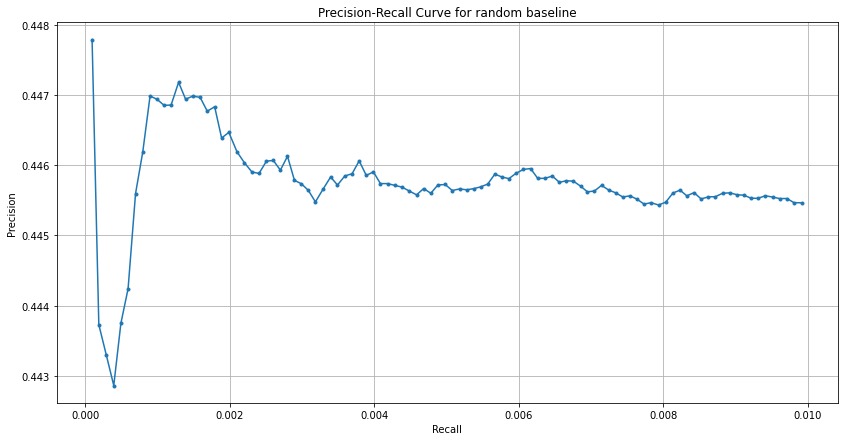

nearly half
word2vec euc-sim
Avg ndcg: 0.1777969629419272
Avg genre diversity: 4.836416471781146
genre coverage: 0.9334532374100719


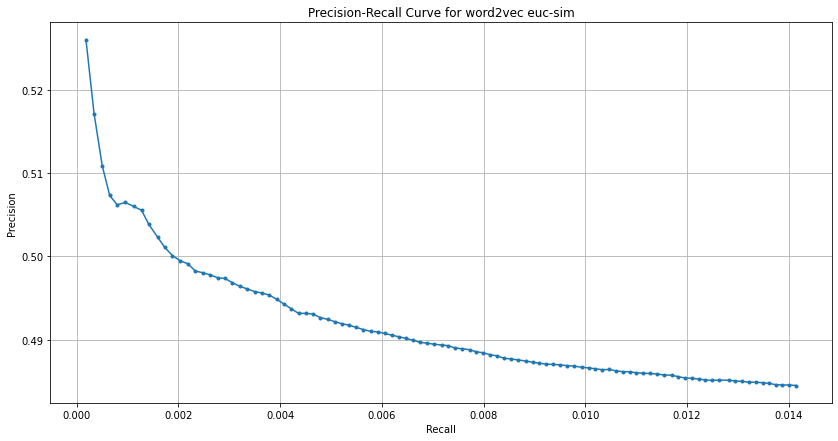

nearly half
tfidf cos-sim
Avg ndcg: 0.17150063532080562
Avg genre diversity: 4.972622666204345
genre coverage: 0.9811151079136691


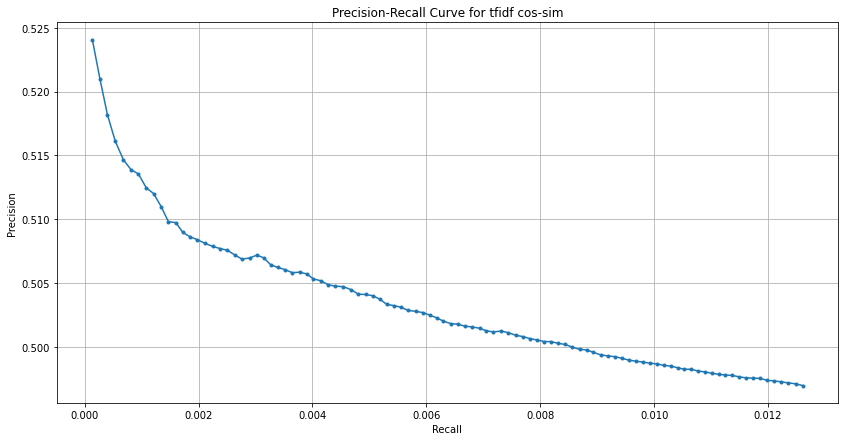

nearly half
bert cos-sim
Avg ndcg: 0.20183773246548498
Avg genre diversity: 4.886813494214937
genre coverage: 0.9127697841726619


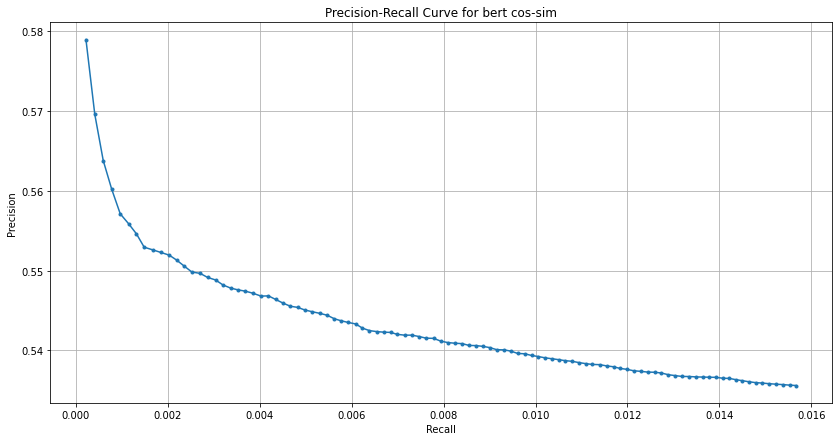

nearly half
mfcc_bow cos-sim
Avg ndcg: 0.22569410026163622
Avg genre diversity: 4.7436668295826
genre coverage: 0.9811151079136691


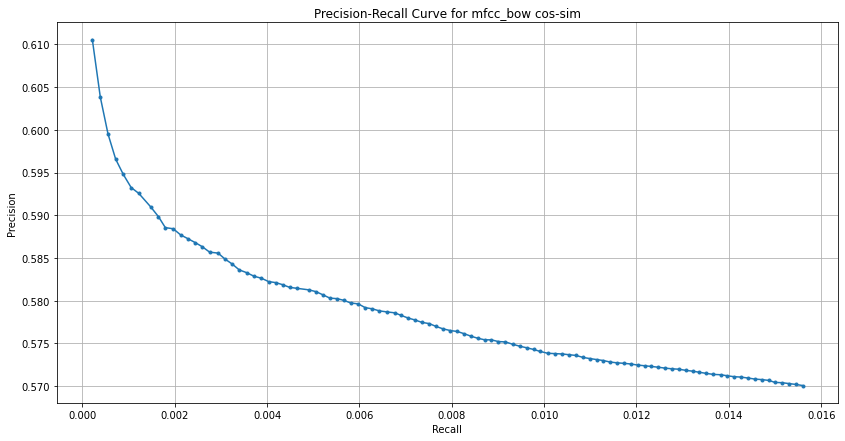

nearly half
musicnn cos-sim
Avg ndcg: 0.24283269583851352
Avg genre diversity: 4.713777377273991
genre coverage: 0.9973021582733813


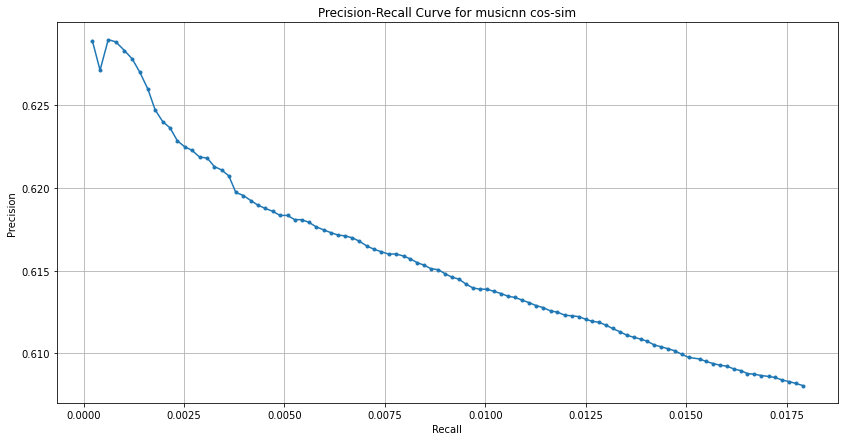

nearly half
ivec_256 cos-sim
Avg ndcg: 0.2183574640258898
Avg genre diversity: 4.90501948427141
genre coverage: 0.9991007194244604


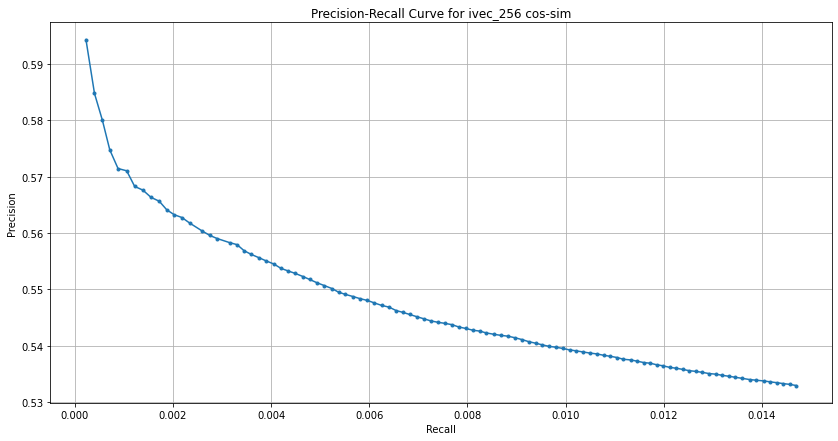

C:\Users\Richard\Desktop\JKU\1.Semester-WS2023\MultimediaSearchAndRetrieval\MMSR-Group-C\2\t2_utils.py:9: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(query,target)/(norm(query)*norm(target))


nearly half
logfluc cos-sim
Avg ndcg: 0.1817986581942194
Avg genre diversity: 4.920141801555555
genre coverage: 0.9487410071942446


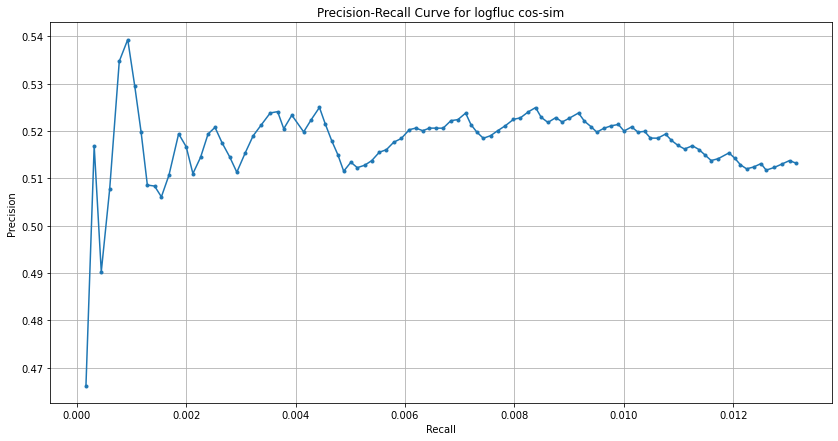

Execution time(min): 238.42944401899973


,Avg ndcg,Avg genre diversity,Genre coverage
random baseline,0.138188,5.056806,1.0
word2vec euc-sim,0.177797,4.836416,0.933453
tfidf cos-sim,0.171501,4.972623,0.981115
bert cos-sim,0.201838,4.886813,0.91277
mfcc_bow cos-sim,0.225694,4.743667,0.981115
musicnn cos-sim,0.242833,4.713777,0.997302
ivec_256 cos-sim,0.218357,4.905019,0.999101
logfluc cos-sim,0.181799,4.920142,0.948741


In [24]:
# Warning: running this can take a long time
# Here we run the pipeline for every system and also print the respective precision recall curve
st = time.time()
k = 10
retr_systems = [("random baseline",df_song_data, t2.cos_sim), ("word2vec euc-sim", df_word2vec, t2.euc_sim), 
                ("tfidf cos-sim", df_tfidf, t2.cos_sim), ("bert cos-sim", df_bert, t2.cos_sim), 
                ("mfcc_bow cos-sim", df_mfcc_bow, t2.cos_sim), ("musicnn cos-sim", df_musicnn, t2.cos_sim), 
                ("ivec_256 cos-sim", df_ivec_256, t2.cos_sim), ("logfluc cos-sim", df_logfluc, t2.cos_sim)]

retr_systems_columns = ["Avg precision", "Avg recall", "Avg ndcg", "Avg genre diversity", "Genre coverage"]
retr_systems_index = [tupl[0] for tupl in retr_systems]

df_metrics = pd.DataFrame(columns=retr_systems_columns, index = retr_systems_index)

for system in retr_systems:
    index, feature_set, sim_func = system
    metrics = t2.evaluation_pipeline(df_song_data, feature_set, sim_func, k, df_song_data.equals(feature_set))
    df_metrics.loc[index] = metrics[2:]
    print(index)
    print("Avg precision:", metrics[2])
    print("Avg recall:", metrics[3])
    print("Avg ndcg:", metrics[4])
    print("Avg genre diversity:", metrics[5])
    print("genre coverage:", metrics[6])
    plt.figure(figsize=(14, 7))
    plt.plot(metrics[1], metrics[0], marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {index}')
    plt.grid(True)
    plt.show()
     
print("Execution time(min):", (time.time()-st)/60)
df_metrics

In [ ]:
# below this cell the evaluation pipeline for every retrieval system is run individually, so it can be ignored

In [ ]:
st = time.time()
metrics_random = t2.evaluation_pipeline(df_song_data, df_song_data, t2.cos_sim, 10, True)
print("random")
print("Avg precision:", metrics_random[2])
print("Avg recall:", metrics_random[3])
print("Avg ndcg:", metrics_random[4])
print("Avg genre diversity:", metrics_random[5])
print("genre coverage:", metrics_random[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_word2vec = t2.evaluation_pipeline(df_song_data, df_word2vec, t2.euc_sim, 10)
print("word2vec")
print("Avg precision:", metrics_word2vec[2])
print("Avg recall:", metrics_word2vec[3])
print("Avg ndcg:", metrics_word2vec[4])
print("Avg genre diversity:", metrics_word2vec[5])
print("genre coverage:", metrics_word2vec[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_tfidf = t2.evaluation_pipeline(df_song_data, df_tfidf, t2.cos_sim, 10)
print("tfidf")
print("Avg precision:", metrics_tfidf[2])
print("Avg recall:", metrics_tfidf[3])
print("Avg ndcg:", metrics_tfidf[4])
print("Avg genre diversity:", metrics_tfidf[5])
print("genre coverage:", metrics_tfidf[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_bert = t2.evaluation_pipeline(df_song_data, df_bert, t2.cos_sim, 10)
print("bert")
print("Avg precision:", metrics_bert[2])
print("Avg recall:", metrics_bert[3])
print("Avg ndcg:", metrics_bert[4])
print("Avg genre diversity:", metrics_bert[5])
print("genre coverage:", metrics_bert[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_mfcc_bow = t2.evaluation_pipeline(df_song_data,df_mfcc_bow, t2.cos_sim, 10)
print("mfcc_bow")
print("Avg precision:", metrics_mfcc_bow[2])
print("Avg recall:", metrics_mfcc_bow[3])
print("Avg ndcg:", metrics_mfcc_bow[4])
print("Avg genre diversity:", metrics_mfcc_bow[5])
print("genre coverage:", metrics_mfcc_bow[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_musicnn = t2.evaluation_pipeline(df_song_data, df_musicnn, t2.cos_sim, 10)
print("musicnn")
print("Avg precision:", metrics_musicnn[2])
print("Avg recall:", metrics_musicnn[3])
print("Avg ndcg:", metrics_musicnn[4])
print("Avg genre diversity:", metrics_musicnn[5])
print("genre coverage:", metrics_musicnn[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_ivec_256 = t2.evaluation_pipeline(df_song_data, df_ivec_256, t2.cos_sim, 10)
print("ivec_256")
print("Avg precision:", metrics_ivec_256[2])
print("Avg recall:", metrics_ivec_256[3])
print("Avg ndcg:", metrics_ivec_256[4])
print("Avg genre diversity:", metrics_ivec_256[5])
print("genre coverage:", metrics_ivec_256[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_logfluc = t2.evaluation_pipeline(df_song_data, df_logfluc, t2.cos_sim, 10)
print("logfluc")
print("Avg precision:", metrics_logfluc[2])
print("Avg recall:", metrics_logfluc[3])
print("Avg ndcg:", metrics_logfluc[4])
print("Avg genre diversity:", metrics_logfluc[5])
print("genre coverage:", metrics_logfluc[6])
print("Execution time(min):", (time.time()-st)/60)